<center><h1>Automatic Roman Numeral Analysis</h1>
<h3>By Aaron Keller, Michael Cuevas, and David Zane </h3>
<h5>EECS 352</h5></center>

In [4]:
# This line is a convenience to import most packages you'll need. You may need to import others (e.g. random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math, csv
from IPython.display import Audio
from sklearn.datasets import load_iris
from chord_training import training_chord_set, training_chord_labels,chord_dictionary,chord_vectors,ks_key_set,ks_key_labels,key_dictionary
import librosa.display
%matplotlib inline

In [5]:
""" FUNCTION TO LOAD DESIGNATED AUDIO"""
def load_audio(audio_path):
    """
    Loads an audio file and returns the signal and sample rate. Also displays an audio player to play original sound
    
    Parameters
    ----------
    audio_path: string
        path to audio file to load
    
    Output
    ----------
    chord,sr: tuple
        contains the signal as index 0 and the sample rate as index 1
    """
    chord,sr = librosa.load(audio_path, sr=None)
    Audio(chord, rate=sr)
    return (chord, sr)


In [6]:
""" PLOTTING FUNCTIONS USED IN HPS ANALYSIS """

def plot_chromogram(signal, sr, n_fft, hop_length):
    """
    Displays a chromogram for a given signal
    
    Parameters
    ----------
    signal: 1D Numpy Array
        contains the original audio signal
    sr: int
        sample rate of the audio signal
    n_fft: int
        number of bins for the short time fourier transform
    hop_length: int
        size of each bin of the fourier transform
    """
    chromagram = librosa.feature.chroma_stft(chord, sr=sr, n_fft=2048, hop_length=1024)
    librosa.display.specshow(chromagram,y_axis='chroma',x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.show()

def plot_fft(FFT, sr):
    """
    Displays a chromogram for a given signal
    
    Parameters
    ----------
    FFT: 1D Numpy Array
        contains the FFT of an audio signal
    sr: int
        sample rate of the audio signal
    """
    Nf = np.shape(FFT)[0]
    below_nyquist = FFT[0:int(Nf/2)+1]

    plt.figure()
    freq_arr = np.arange(int(Nf/2)+1) * (sr/Nf)
    plt.plot(freq_arr, below_nyquist)
    #plt.xlim([0,2000])
    #print(np.max(fft_chroma_test))
    
def plot_hps(hps, sr, type_sig):
    """
    Plots the harmonic product spectrum
    
    Parameters
    ----------
    hps: 1D Numpy Array
        contains the harmonic product spectrum of a signal
    type_sig: string
        contains the type of hps (either 'guitar' or 'piano')
    sr: int
        sample rate of the original audio signal
    """
    if(type_sig == 'guitar'):
        num_dec = 2**4
    else:
        num_dec = 2**2
    
    hps_max = np.amax(hps)
    hps = hps/hps_max
    
    plt.figure()
    win_len = len(hps)
    freq_arr = np.arange(win_len) * ((sr/num_dec)/win_len)
    plt.xlim([0,1000])
    plt.plot(freq_arr, hps)
    

In [7]:
""" FUNCTIONS USED FOR SIGNAL ANALYSIS """

def magnitude_spectrogram(signal, sr):
    """
    Displays a chromogram for a given signal
    
    Parameters
    ----------
    signal: 1D Numpy Array
        contains the original audio signal
    sr: int
        sample rate of the audio signal
    Output
    ----------
    FFT: 1D Numpy Array
        contains the magnitude spectrogram of the original signal
    """
    FFT = np.abs(np.fft.fft(signal))
    #fft_chroma_test = np.abs(fft_chroma_test)
    Nf = np.shape(FFT)[0]
    FFT = FFT[0:int(Nf/2)+1]
    return FFT

def hps_piano(mag_spec):
    """
    Calculates the harmonic product spectrum for a piano
    
    Parameters
    ----------
    mag_spec: 1D Numpy Array
        contains the magnitude spectrogram of the signal
    Output
    ----------
    hps: 1D Numpy Array
        contains the harmonic product spectrum
    """
    # decimates the audio 3 times
    dec1 = sp.signal.decimate(mag_spec, 1)
    dec2 = sp.signal.decimate(mag_spec, 2)
    dec3 = sp.signal.decimate(mag_spec, 4)
    
    # multiplies the decimated audio together to reduce overtones
    hps = np.zeros(len(dec3))
    for i in range(len(dec3)):
        product = dec1[i] * dec2[i] * dec3[i]
        hps[i] = product
    return hps

def hps_guitar(mag_spec):
    """
    Calculates the harmonic product spectrum for a guitar
    
    Parameters
    ----------
    mag_spec: 1D Numpy Array
        contains the magnitude spectrogram of the signal
    Output
    ----------
    hps: 1D Numpy Array
        contains the harmonic product spectrum
    """
    # decimates the audio signal 5 times to reduce overtones
    dec1 = sp.signal.decimate(mag_spec, 1)
    dec2 = sp.signal.decimate(mag_spec, 2)
    dec3 = sp.signal.decimate(mag_spec, 4)
    dec4 = sp.signal.decimate(mag_spec, 8)
    dec5 = sp.signal.decimate(mag_spec, 16)
    
    # multiplies the decimated audio together to reduce overtones
    hps = np.zeros(len(dec5))
    for i in range(len(dec5)):
        product = dec1[i] * dec2[i] * dec3[i] * dec4[i] * dec5[i]
        hps[i] = product
    return hps



In [8]:
def chromagram(hps,type_sig):
    """
    Generates a 12-bin chromagram from a harmonic product spectrum
    
    Parameters
    ----------
    hps: 1D Numpy Array
    bins: # of chromagram bins desired
       
    Output
    ----------
    chroma_vec: 1D Numpy Array with shape=(1,12)
    """
    
    # initialize output vector
    chroma_vec = np.zeros((12))
    
    if(type_sig == 'guitar'):
        num_dec = 2**4
    else:
        num_dec = 2**2
    
    #hps_max = np.amax(hps)
    #hps = hps/hps_max
    
    plt.figure()
    win_len = len(hps)
    freq_arr = np.arange(win_len) * ((sr/num_dec)/win_len)
    
    # do log2(freq) - floor(log2(freq)) for each element in hps
    # results in a # in range (0,1)
    for i in range(len(freq_arr)):
        if hps[i] <= 0:
            continue
        else:
            cbin = find_chroma_bin(freq_arr[i])
            chroma_vec[cbin] = chroma_vec[cbin] + hps[i]
      
    #scale chroma_vec between 0 and 1
    cmax = np.amax(chroma_vec)
    chroma_vec = chroma_vec / cmax
    
    # plot 12-bin chromagram
    plt.plot(np.linspace(0,11,12), chroma_vec, 'bo')
    plt.xlabel("Note Number")
    plt.show()
    
    return chroma_vec

def find_chroma_bin(freq):
    bin = 0
    i = np.log2(freq) - np.floor(np.log2(freq))
    if i < 1.0/12:
        bin = 0
    elif i>=1.0/12 and i<2.0/12:
        bin = 1
    elif i>=2.0/12 and i<3.0/12:
        bin = 2
    elif i>=3.0/12 and i<4.0/12:
        bin = 3
    elif i>=4.0/12 and i<5.0/12:
        bin = 4
    elif i>=5.0/12 and i<6.0/12:
        bin = 5
    elif i>=6.0/12 and i<7.0/12:
        bin = 6
    elif i>=7.0/12 and i<8.0/12:
        bin = 7
    elif i>=8.0/12 and i<9.0/12:
        bin = 8
    elif i>=9.0/12 and i<10.0/12:
        bin = 9
    elif i>=10.0/12 and i<11.0/12:
        bin = 10
    elif i>=11.0/12:
        bin = 11
    return bin


In [9]:
''' ########## KNN CHORD CLASSIFIER ########## '''
def knn(data_X, data_Y, query_X, dist_measure, k):
    query_rows = query_X.shape[0]
    data_rows = data_X.shape[0]
    cols = query_X.shape[1]
    res = np.zeros(query_rows)
    
    #iterate through each test example
    for i in range(query_rows):
        dist_arr = [None] * data_rows
        #iterate through the data examples and add the distance between each point and the test points to the distance array
        #as an array of tuples (index,distance)
        for j in range(data_rows):
            if dist_measure == 'euclidean':
                dist_arr[j] = (j,sp.spatial.distance.euclidean(query_X[i,:],data_X[j,:],2))
            elif dist_measure == 'cosine':
                dist_arr[j] = (j,sp.spatial.distance.cosine(query_X[i,:],data_X[j,:]))
                
        #Sort the array in ascending order by distance
        sorted_arr = sorted(dist_arr, key=lambda x:x[1])
        #Only need the first 'k' elements of the array
        k_neighbors = sorted_arr[0:k]
        classes = np.zeros(k)
        #create an array of class types corresponding to the classes of the elements in k_neighbors
        for l in range(k):
            index = k_neighbors[l][0]
            dclass = data_Y[index]
            classes[l] = dclass
        #Find the most common class type in classes[] by taking the mode
        closest = int(sp.stats.mode(classes)[0][0])
        res[i] = int(closest)
    return res


In [19]:
'''Krumhansl-Schmuckler Key Finding Algorithm'''
def create_key_time_vector(chord_progression):
    chords_vec = np.zeros(shape=(len(chord_progression),12))
    for i in range(len(chord_progression)):
        chords_vec[i,:] = chord_vectors[chord_progression[i]]
    key_time_vector = np.sum(chords_vec,axis=0)
    return key_time_vector

def ks(kt_vector):
    r_vector = np.zeros(24)
    for i in range(ks_key_set.shape[0]):
        r,p = sp.stats.pearsonr(ks_key_set[i,:],kt_vector)
        r_vector[i] = r
    key_index = np.argmax(r_vector)
    return key_dictionary[str(key_index)]
        

spec
[1.5011724  2.3184848  1.4239873  ... 0.0134092  0.01447554 0.01525009]
hps ------------
[3.44529606e+00 1.09996417e+01 1.82640600e+01 ... 8.27321697e-04
 1.48864652e-03 5.25065936e-04]
1th largest value: 393.11899038461536

2th largest value: 262.8155048076923

3rd largest value: 329.0715144230769

4th largest value: 525.6310096153846

5th largest value: 390.9104567307692

6th largest value: 331.28004807692304

7th largest value: 660.3515625

8th largest value: 658.1430288461538

9th largest value: 786.2379807692307

10th largest value: 165.64002403846152



C:\Users\akell\AppData\Local\Continuum\anaconda3\envs\eecs352\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\akell\AppData\Local\Continuum\anaconda3\envs\eecs352\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


'\nplt.figure(0)\nwin_len2 = len(hps1)\nfreq_arr2 = np.arange(win_len2) * ((sr/2)/win_len2)\nplt.plot(freq_arr2, hps1)\n#plt.xlim([0,2000])\n\nplt.figure(1)\nhps2 = sp.signal.decimate(fft_chord, 8)\nwin_len2 = len(hps2)\nfreq_arr2 = np.arange(win_len2) * ((sr/8)/win_len2)\nplt.plot(freq_arr2, hps2)\nplt.xlim([0,2000])\n\n\n# Calculation for HPS \n\ny = np.zeros(len(hps5))\nfor i in range(len(hps5)):\n    product = hps1[i] * hps2[i] * hps3[i] * hps4[i] * hps5[i]\n    y[i] = product\n\n# Plot for HPS\n\nplt.figure(0)\nwin_len2 = len(y)\nfreq_arr2 = np.arange(win_len2) * ((sr/16)/win_len2)\nplt.xlim([0,500])\nplt.plot(freq_arr2, y)\n\nfft_chroma_test = np.fft.fft(chord)\nfft_chroma_test = np.abs(fft_chroma_test)\nNf = np.shape(fft_chroma_test)[0]\nfft_chroma_test = fft_chroma_test[0:int(Nf/2)+1] \n\n\nplt.figure(1)\nfreq_arr = np.arange(int(Nf/2)+1) * (sr/Nf)\nplt.plot(freq_arr,fft_chroma_test)\nplt.xlim([0,500])\nprint(np.max(fft_chroma_test))\nind = np.argsort(y)\nind = ind*((sr/16)/win

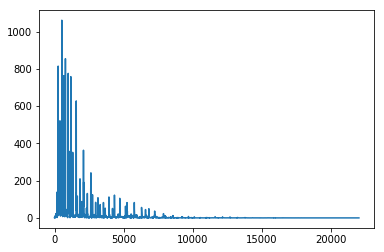

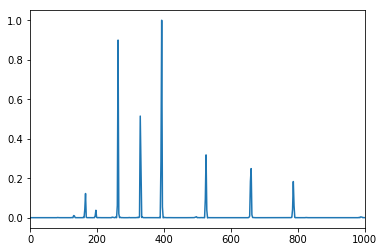

In [8]:
#chord = sp.signal.windows.hann(len(chord)) * chord

# load in audio file and specify sound type ('guitar' or 'piano')
path = 'c.wav'
sig_type = 'piano'
chord, sr = load_audio(path)
display(Audio(chord,rate =sr))

# calculate magnitude spectrogram with values up to nyquist frequency and plot
spec = magnitude_spectrogram(chord, sr)
plot_fft(spec, sr)

print("spec")
print(spec)

# use HPS algorithm to reduce overtones
if(sig_type == 'guitar'):
    hps = hps_guitar(spec)
else:
    hps = hps_piano(spec)
    
# plot HPS output
print("hps ------------")
print(hps)
plot_hps(hps, sr, sig_type)

# output information about chord analysis

Nf = np.shape(hps)[0]
indices = np.argsort(hps)
if(sig_type == 'guitar'):
    indices = indices*((sr/16)/Nf)
else:
    indices = indices*((sr/4)/Nf)
length = np.shape(indices)[0]
indexName = ''
for i in range(10):
    if(i == 0):
        indexName = "1st "
    if(i == 1):
        indexName = "2nd "
    if(i == 2):
        indexName = "3rd "
    else:
        indexName = str(i+1) + "th "
    print(indexName + "largest value: " + str(indices[length-1-i]) + "\n")


'''
plt.figure(0)
win_len2 = len(hps1)
freq_arr2 = np.arange(win_len2) * ((sr/2)/win_len2)
plt.plot(freq_arr2, hps1)
#plt.xlim([0,2000])

plt.figure(1)
hps2 = sp.signal.decimate(fft_chord, 8)
win_len2 = len(hps2)
freq_arr2 = np.arange(win_len2) * ((sr/8)/win_len2)
plt.plot(freq_arr2, hps2)
plt.xlim([0,2000])


# Calculation for HPS 

y = np.zeros(len(hps5))
for i in range(len(hps5)):
    product = hps1[i] * hps2[i] * hps3[i] * hps4[i] * hps5[i]
    y[i] = product

# Plot for HPS

plt.figure(0)
win_len2 = len(y)
freq_arr2 = np.arange(win_len2) * ((sr/16)/win_len2)
plt.xlim([0,500])
plt.plot(freq_arr2, y)

fft_chroma_test = np.fft.fft(chord)
fft_chroma_test = np.abs(fft_chroma_test)
Nf = np.shape(fft_chroma_test)[0]
fft_chroma_test = fft_chroma_test[0:int(Nf/2)+1] 


plt.figure(1)
freq_arr = np.arange(int(Nf/2)+1) * (sr/Nf)
plt.plot(freq_arr,fft_chroma_test)
plt.xlim([0,500])
print(np.max(fft_chroma_test))
ind = np.argsort(y)
ind = ind*((sr/16)/win_len2)
leng = np.shape(ind)[0]
print(str(ind[leng-4:leng]))

'''



C:\Users\akell\AppData\Local\Continuum\anaconda3\envs\eecs352\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
C:\Users\akell\AppData\Local\Continuum\anaconda3\envs\eecs352\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


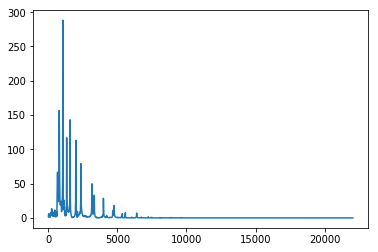

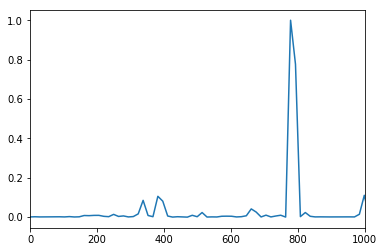

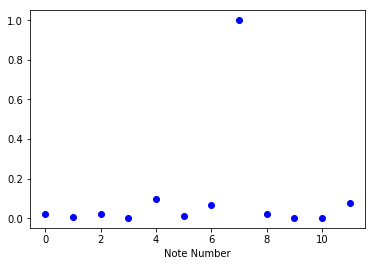


CHORD AT SAMPLE NUMBER: 1537

1th largest value: 778.0625832223701

2th largest value: 792.7430093209055

3rd largest value: 998.2689747003994

4th largest value: 381.69107856191744

5th largest value: 337.64980026631156

6th largest value: 396.37150466045273

7th largest value: 660.6191744340879

8th largest value: 675.2996005326231

9th largest value: 513.814913448735

10th largest value: 822.1038615179759



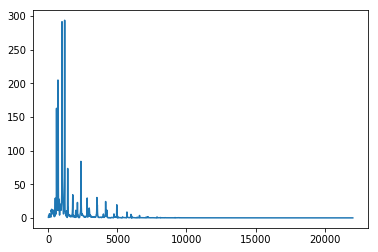

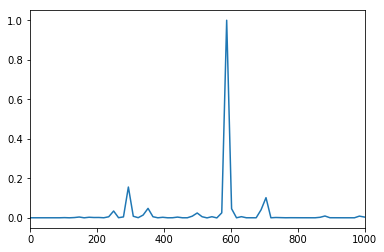

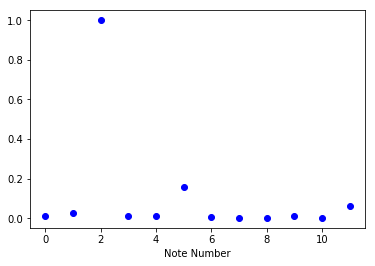


CHORD AT SAMPLE NUMBER: 163329

1th largest value: 587.2170439414115

2th largest value: 293.60852197070574

3rd largest value: 704.6604527296937

4th largest value: 352.33022636484685

5th largest value: 601.8974700399467

6th largest value: 689.9800266311585

7th largest value: 249.56724367509986

8th largest value: 572.5366178428761

9th largest value: 499.1344873501997

10th largest value: 1174.434087882823



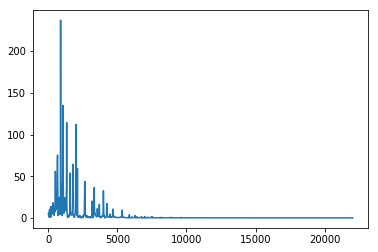

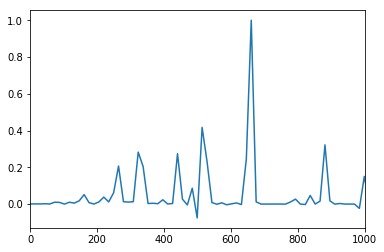

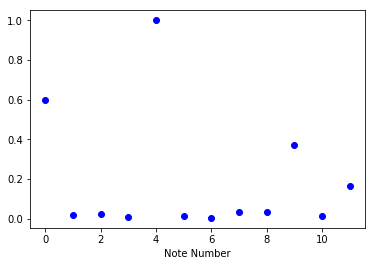


CHORD AT SAMPLE NUMBER: 326145

1th largest value: 660.6191744340879

2th largest value: 513.814913448735

3rd largest value: 880.8255659121171

4th largest value: 322.96937416777627

5th largest value: 440.41278295605855

6th largest value: 645.9387483355525

7th largest value: 528.4953395472703

8th largest value: 264.24766977363515

9th largest value: 337.64980026631156

10th largest value: 998.2689747003994

['E_m_' 'B_o_' 'A_m_']


"\nchord,sr = load_audio('chords.wav')\nchord = chord[0:400000]\nprint(len(chord))\ngraph_chromogram(chord, sr=sr, n_fft=2048, hop_length=1024)\nAudio(chord[0:400000], rate=sr)\n\ntimes = librosa.onset.onset_detect(y=chord, sr=sr, units='samples')\nprint(times)\nplt.plot(chord)\n\n\nfor i in times:\n    # Graph Chromogram of initial audio\n    '''\n    chromagram = librosa.feature.chroma_stft(chord[i:i+4000], sr=sr, n_fft=2048, hop_length=1024)\n    librosa.display.specshow(chromagram,y_axis='chroma',x_axis='time')\n    plt.figure(i+2)\n    plt.colorbar()\n    plt.title('Chromagram')\n    plt.tight_layout()\n    plt.show()\n    '''\n    \n    #calc FFT\n    fft_chroma_test = np.fft.fft(chord[i:i+8000])\n    fft_chroma_test = np.abs(fft_chroma_test)\n    Nf = np.shape(fft_chroma_test)[0]\n    fft_chroma_test = fft_chroma_test[0:int(Nf/2)+1] \n    \n    #plots FFT\n    plt.figure(i)\n    freq_arr = np.arange(int(Nf/2)+1) * (sr/Nf)\n    plt.plot(freq_arr,fft_chroma_test)\n    #plt.xlim([0

In [24]:
# load in audio file and specify sound type ('guitar' or 'piano')
path = 'chords.wav'
sig_type = 'piano'
chord, sr = load_audio(path)
chord = chord[0:400000]
display(Audio(chord, rate=sr))

times = librosa.onset.onset_detect(y=chord, sr=sr, units='samples')

chord_progression = np.zeros(shape=(len(times),12))
counter = 0

# for each onset (chord) detected
for i in times:
    # calculate magnitude spectrogram with values up to nyquist frequency and plot
    spec = magnitude_spectrogram(chord[i:i+6000], sr)
    plot_fft(spec, sr)

    # use HPS algorithm to reduce overtones
    if(sig_type == 'guitar'):
        hps = hps_guitar(spec)
    else:
        hps = hps_piano(spec)

    # plot HPS output
    plot_hps(hps, sr, sig_type)
    v = chromagram(hps,sig_type)
    chord_progression[counter,:] = v
    # output information about chord analysis

    Nf = np.shape(hps)[0]
    indices = np.argsort(hps)
    if(sig_type == 'guitar'):
        indices = indices*((sr/16)/Nf)
    else:
        indices = indices*((sr/4)/Nf)
    length = np.shape(indices)[0]
    indexName = ''
    print("\nCHORD AT SAMPLE NUMBER: " + str(i+1) + "\n")
    for j in range(10):
        if(j == 0):
            indexName = "1st "
        if(j == 1):
            indexName = "2nd "
        if(j == 2):
            indexName = "3rd "
        else:
            indexName = str(j+1) + "th "
        print(indexName + "largest value: " + str(indices[length-1-j]) + "\n")
    
    counter = counter + 1

labels = knn(training_chord_set, training_chord_labels,chord_progression, 'cosine',1)
chord_names = [None] * len(labels)
for i in range(len(labels)):
    chord_names[i] = chord_dictionary[str(int(labels[i]))]
chord_names = np.array(chord_names)
print(chord_names)

"""
chord,sr = load_audio('chords.wav')
chord = chord[0:400000]
print(len(chord))
graph_chromogram(chord, sr=sr, n_fft=2048, hop_length=1024)
Audio(chord[0:400000], rate=sr)

times = librosa.onset.onset_detect(y=chord, sr=sr, units='samples')
print(times)
plt.plot(chord)


for i in times:
    # Graph Chromogram of initial audio
    '''
    chromagram = librosa.feature.chroma_stft(chord[i:i+4000], sr=sr, n_fft=2048, hop_length=1024)
    librosa.display.specshow(chromagram,y_axis='chroma',x_axis='time')
    plt.figure(i+2)
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.show()
    '''
    
    #calc FFT
    fft_chroma_test = np.fft.fft(chord[i:i+8000])
    fft_chroma_test = np.abs(fft_chroma_test)
    Nf = np.shape(fft_chroma_test)[0]
    fft_chroma_test = fft_chroma_test[0:int(Nf/2)+1] 
    
    #plots FFT
    plt.figure(i)
    freq_arr = np.arange(int(Nf/2)+1) * (sr/Nf)
    plt.plot(freq_arr,fft_chroma_test)
    #plt.xlim([0,2000])
    #print(np.max(fft_chroma_test))
    
    # Decimates the FFT (downsamples)
    hps1 = sp.signal.decimate(fft_chroma_test, 1)
    print(np.shape(hps1))
    hps2 = sp.signal.decimate(fft_chroma_test, 2)
    print(np.shape(hps2))
    hps3 = sp.signal.decimate(fft_chroma_test, 4)
    print(np.shape(hps3))
    #hps4 = sp.signal.decimate(fft_chroma_test, 8)
    #hps5 = sp.signal.decimate(fft_chroma_test, 16)
   #hps6 = sp.signal.decimate(fft_chroma_test, 32)
    
    #calculates HPS
    y = np.zeros(len(hps3))
    for j in range(len(hps3)):
        product = hps1[j] * hps2[j] * hps3[j] #* hps4[j] * hps5[j] * hps6[j]
        y[j] = product

    # Plot for HPS

    plt.figure(i+1)
    win_len2 = len(y)
    freq_arr2 = np.arange(win_len2) * ((sr/4)/win_len2)
    plt.xlim([0,1000])
    plt.plot(freq_arr2, y)
    
    '''
    # Plots original FFT for comparison
    fft_chroma_test = np.fft.fft(chord)
    fft_chroma_test = np.abs(fft_chroma_test)
    Nf = np.shape(fft_chroma_test)[0]
    fft_chroma_test = fft_chroma_test[0:int(Nf/2)+1] 
    plt.figure(1)
    '''
    #plots HPS and finds 4 largest peaks
    freq_arr = np.arange(int(Nf/2)+1) * (sr/Nf)
    plt.plot(freq_arr,fft_chroma_test)
    print(np.max(fft_chroma_test))
    ind = np.argsort(y)
    ind = ind*((sr/4)/win_len2)
    leng = np.shape(ind)[0]
    print(str(ind[leng-7:leng]))
    """


[  8192  32768 123904 227840 338944 439296]


C:\Users\akell\AppData\Local\Continuum\anaconda3\envs\eecs352\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
C:\Users\akell\AppData\Local\Continuum\anaconda3\envs\eecs352\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


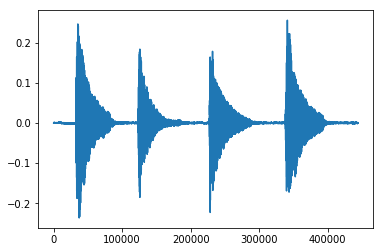

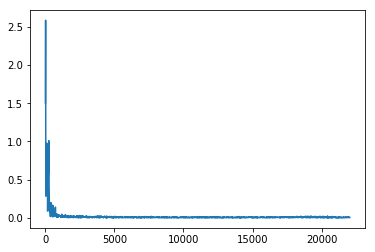

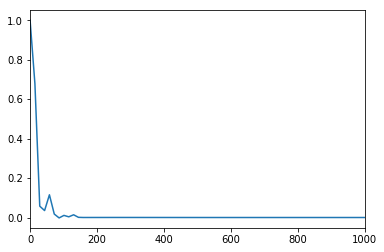

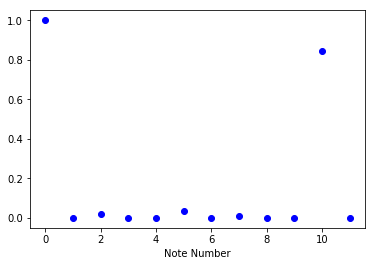


CHORD AT SAMPLE NUMBER: 8193

1th largest value: 0.0

2th largest value: 14.44954128440367

3rd largest value: 57.79816513761468

4th largest value: 28.89908256880734

5th largest value: 43.34862385321101

6th largest value: 72.24770642201835

7th largest value: 130.04587155963304

8th largest value: 101.1467889908257

9th largest value: 115.59633027522936

10th largest value: 144.4954128440367



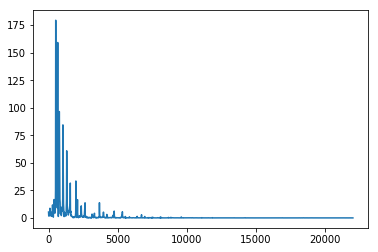

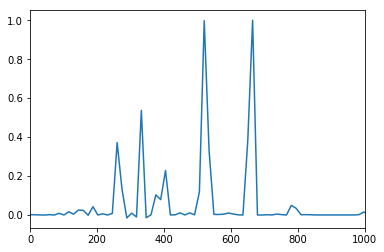

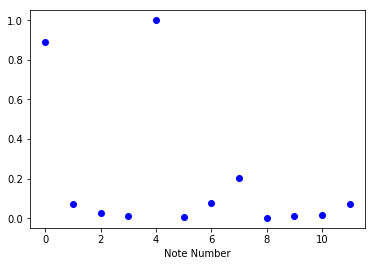


CHORD AT SAMPLE NUMBER: 32769

1th largest value: 664.6788990825688

2th largest value: 520.1834862385322

3rd largest value: 332.3394495412844

4th largest value: 650.2293577981652

5th largest value: 260.0917431192661

6th largest value: 534.6330275229358

7th largest value: 404.5871559633028

8th largest value: 274.54128440366975

9th largest value: 505.73394495412845

10th largest value: 375.6880733944954



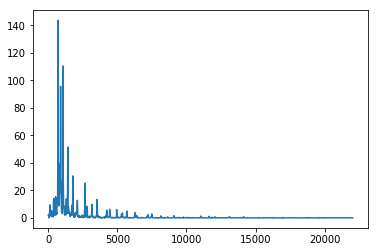

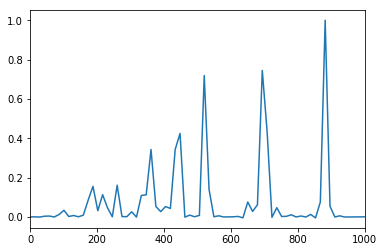

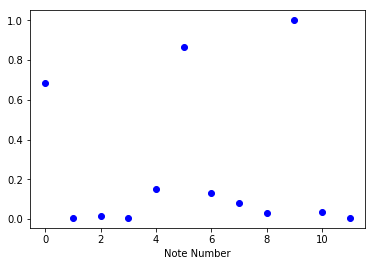


CHORD AT SAMPLE NUMBER: 123905

1th largest value: 881.4220183486239

2th largest value: 693.5779816513761

3rd largest value: 520.1834862385322

4th largest value: 708.0275229357799

5th largest value: 447.9357798165138

6th largest value: 433.4862385321101

7th largest value: 361.23853211009174

8th largest value: 1054.8165137614678

9th largest value: 260.0917431192661

10th largest value: 187.8440366972477



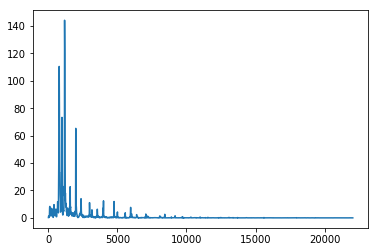

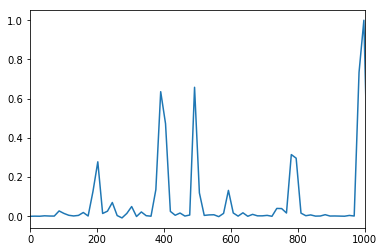

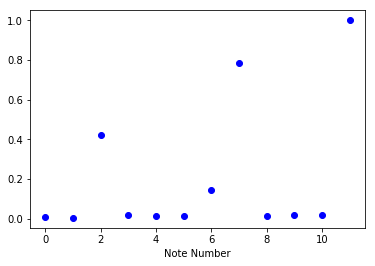


CHORD AT SAMPLE NUMBER: 227841

1th largest value: 997.0183486238533

2th largest value: 1184.8623853211009

3rd largest value: 982.5688073394496

4th largest value: 491.2844036697248

5th largest value: 390.1376146788991

6th largest value: 404.5871559633028

7th largest value: 780.2752293577983

8th largest value: 794.7247706422019

9th largest value: 202.2935779816514

10th largest value: 375.6880733944954



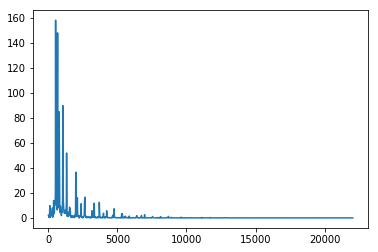

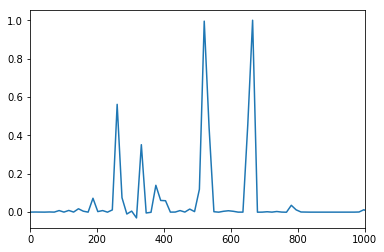

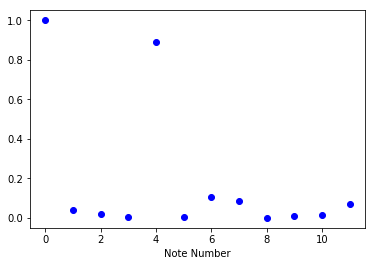


CHORD AT SAMPLE NUMBER: 338945

1th largest value: 664.6788990825688

2th largest value: 520.1834862385322

3rd largest value: 260.0917431192661

4th largest value: 650.2293577981652

5th largest value: 534.6330275229358

6th largest value: 332.3394495412844

7th largest value: 375.6880733944954

8th largest value: 505.73394495412845

9th largest value: 274.54128440366975

10th largest value: 187.8440366972477



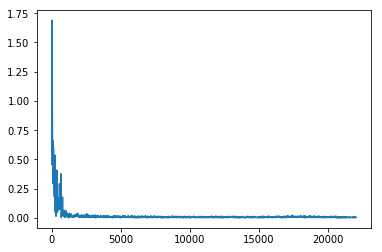

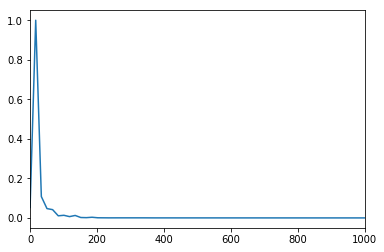

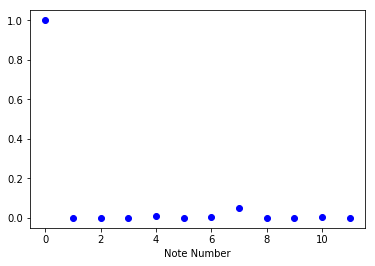


CHORD AT SAMPLE NUMBER: 439297

1th largest value: 16.83206106870229

2th largest value: 33.66412213740458

3rd largest value: 0.0

4th largest value: 50.49618320610688

5th largest value: 67.32824427480917

6th largest value: 100.99236641221376

7th largest value: 134.65648854961833

8th largest value: 84.16030534351145

9th largest value: 117.82442748091604

10th largest value: 185.1526717557252

['C_m7' 'C_M_' 'F_M_' 'G_M_' 'C_M_' 'C_M_']
[5. 0. 1. 1. 3. 1. 0. 5. 0. 1. 1. 1.]
Key:  C Major


In [22]:
path = './Audio/I-IV-V-I.wav'
sig_type = 'piano'
chord, sr = load_audio(path)
display(Audio(chord, rate=sr))

plt.figure(100)
plt.plot(chord)
plt.plot([7680],[0])

times = librosa.onset.onset_detect(y=chord, sr=sr, units='samples')
print(times)

chord_progression = np.zeros(shape=(len(times),12))
counter = 0

# for each onset (chord) detected
for i in times:
    # calculate magnitude spectrogram with values up to nyquist frequency and plot
    spec = magnitude_spectrogram(chord[i:i+6100], sr)
    plot_fft(spec, sr)

    # use HPS algorithm to reduce overtones
    if(sig_type == 'guitar'):
        hps = hps_guitar(spec)
    else:
        hps = hps_piano(spec)

    # plot HPS output
    plot_hps(hps, sr, sig_type)
    v = chromagram(hps,sig_type)
    chord_progression[counter,:] = v
    # output information about chord analysis

    Nf = np.shape(hps)[0]
    indices = np.argsort(hps)
    if(sig_type == 'guitar'):
        indices = indices*((sr/16)/Nf)
    else:
        indices = indices*((sr/4)/Nf)
    length = np.shape(indices)[0]
    indexName = ''
    print("\nCHORD AT SAMPLE NUMBER: " + str(i+1) + "\n")
    for j in range(10):
        if(j == 0):
            indexName = "1st "
        if(j == 1):
            indexName = "2nd "
        if(j == 2):
            indexName = "3rd "
        else:
            indexName = str(j+1) + "th "
        print(indexName + "largest value: " + str(indices[length-1-j]) + "\n")
    
    counter = counter + 1

labels = knn(training_chord_set, training_chord_labels,chord_progression, 'cosine',1)
chord_names = [None] * len(labels)
for i in range(len(labels)):
    chord_names[i] = chord_dictionary[str(int(labels[i]))]
chord_names = np.array(chord_names)
print(chord_names)
key_time = create_key_time_vector(chord_names)
print(key_time)
key = ks(key_time)
print('Key: ',key)